In [1]:
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt

In [2]:
def accumulator(canny):
    max_dist = np.sqrt(np.square(canny.shape[0])+np.square(canny.shape[1]))
    theta = np.deg2rad(np.arange(-90.0, 90.0))
    rho_range = np.arange(-max_dist, max_dist)

    # Accumulator  (Voting Bin)
    accumulator_matrix = np.zeros((len(rho_range),len(theta)),dtype=int)

    y,x = np.nonzero(canny)

    for i in range(len(x)):
        for j in range(len(theta)):
            rho = ((x[i] * np.cos(theta[j])) + (y[i] * np.sin(theta[j]))) + max_dist # Adding max_dist to get the minimum distance as zero
            # print(rho,", ",j)
            accumulator_matrix[round(rho),j] += 1
    return accumulator_matrix, rho_range, theta

def find_peaks(accumulator_matrix, rho_range, theta, kernal_size, frame):
    peaks = []
    accumulator_matrix1 = np.copy(accumulator_matrix)
    for i in range(4):
      accumulator_matrix1_idx = np.unravel_index(np.argmax(accumulator_matrix1), accumulator_matrix1.shape)
      peaks.append(accumulator_matrix1_idx)

      # surpess peaks in neighborhood
      y_i, x_i = accumulator_matrix1_idx 
      if (x_i - (kernal_size//2)) < 0:
        x_min = 0
      else:
        x_min = x_i - (kernal_size//2)
      if ((x_i + (kernal_size//2) + 1) > accumulator_matrix.shape[1]):
        max_x = accumulator_matrix.shape[1]
      else:
        max_x = x_i + (kernal_size//2) + 1

      if (y_i - (kernal_size//2)) < 0:
        min_y = 0
      else:
        min_y = y_i - (kernal_size//2)
      if ((y_i + (kernal_size//2) + 1) > accumulator_matrix.shape[0]):
        max_y = accumulator_matrix.shape[0]
      else:
        max_y = y_i + (kernal_size//2) + 1

      for x in range(x_min, max_x):
          for y in range(min_y, max_y):
              accumulator_matrix1[y, x] = 0
              if (x == x_min or x == (max_x - 1)):
                  accumulator_matrix[y, x] = 255
              if (y == min_y or y == (max_y - 1)):
                  accumulator_matrix[y, x] = 255

    # Hough Lines
    #print(len(peaks))
    rho_peaks = []
    theta_peaks = []
    for i in range(len(peaks)):
      rho_peak = rho_range[peaks[i][0]]
      rho_peaks.append(rho_peak)
      theta_peak = theta[peaks[i][1]]
      theta_peaks.append(theta_peak)
      # Draw Hough Lines
      x1 = int(np.cos(theta_peak)*rho_peak + 2500*(-np.sin(theta_peak)))
      y1 = int(np.sin(theta_peak)*rho_peak + 2500*(np.cos(theta_peak)))
      x2 = int(np.cos(theta_peak)*rho_peak - 2500*(-np.sin(theta_peak)))
      y2 = int(np.sin(theta_peak)*rho_peak - 2500*(np.cos(theta_peak)))
      cv.line(frame, (x1, y1), (x2, y2), (125, 225, 255), 1)
      # print(len(rho_peaks))

    return rho_peaks, theta_peaks

def find_corners(rho_peaks, theta_peaks):
    # print(rho_peaks)
    # print(theta_peaks)

    neg = []
    pos = []
    corners = []

    for i in range(len(theta_peaks)):
        if theta_peaks[i]<0:
          neg.append([rho_peaks[i],theta_peaks[i]])  
          # print('neg++') 
        else:
          pos.append([rho_peaks[i],theta_peaks[i]])
          # print('pos++')
    # print('neg = ',neg)
    # print('pos = ',pos)
    for j in neg:
        # print('in loop 1')
        for k in pos:
            # print('in loop 2')
            A= np.array([[np.cos(j[1]), np.sin(j[1])],
                         [np.cos(k[1]), np.sin(k[1])]])
            A_inv = np.linalg.inv(A)

            B= np.array([j[0], k[0]])
            
            mat = np.matmul(A_inv,B.T)
            
            corners.append([int(mat[0]),int(mat[1])])
            # print('corner++')

    corners = sorted(corners, key = lambda x:x[0] + x[1])
    # print(corners)
    
    return corners

def transform(corners,paper,intrinsic_parameters):
    ip_inv = np.linalg.inv(intrinsic_parameters)
    A = np.zeros((2,9))
    for i in range(len(corners)):
        a_i = np.array([[paper[i][0],paper[i][1],1,0,0,0,(-corners[i][0]*paper[i][0]),(-corners[i][0]*paper[i][1]),-corners[i][0]],
                        [0,0,0,paper[i][0],paper[i][1],1,(-corners[i][1]*paper[i][0]),(-corners[i][1]*paper[i][1]),-corners[i][1]]])
        A = np.vstack((A,a_i))
    A = A[2:]
    eigenvalues, eigenvectors = np.linalg.eig(np.dot(A.T,A))
    eigenvalues_idx = np.argmin(eigenvalues)          
    H = eigenvectors[:,eigenvalues_idx]

    H = (1/H[-1])*H
    
    H_final = np.array([[H[0],H[1],H[2]],[H[3],H[4],H[5]],[H[6],H[7],H[8]]])
    
    Transf = np.dot(ip_inv,H_final)
    
    lamb = (np.linalg.norm(Transf[:,0])+np.linalg.norm(Transf[:,1]))/2
    
    Transf = (1/lamb)*Transf
    r1= Transf[:,0]
    r2= Transf[:,1]
    r3= np.cross(Transf[:,0],Transf[:,1])
    t= Transf[:,2]
    
    return r1,r2,r3,t

In [11]:
video = cv.VideoCapture("project2.avi")

# Display Video
if (video.isOpened()== False): 
  print("Error opening video stream or file")

translation = []
rotation = []

# Read until video is completed
while(video.isOpened()):
  # read frame-by-frame
  ret, frame = video.read()
  if ret == True:
    
    gray = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)
    gaussian_blur = cv.GaussianBlur(gray,(7,7),cv.BORDER_DEFAULT)     
    canny = cv.Canny(gaussian_blur,125,200,apertureSize=3)
    accumulator_matrix, rho_range, theta = accumulator(canny)
    rho, theta = find_peaks(accumulator_matrix, rho_range, theta, kernal_size=52, frame=frame)
    # print("rho = ",rho)
    # print("theta = ",theta)
    corners = find_corners(rho,theta)
    
    intrinsic_parameters = np.array([[1382.58398,0,945.743164],
                                     [0,1383.57251,527.04834],
                                     [0,0,1]])

    paper = [(0,27.9),
                 (21.6,27.9),
                 (0,0),
                 (21.6,0)]

    r1,r2,r3,t = transform(corners,paper,intrinsic_parameters)
    
    translation.append(np.array(t))
    rotation.append(np.array([r1,r2,r3]))
    for i in corners:
      frame = cv.circle(frame, (i[0],i[1]), radius=0, color=(0, 0, 255), thickness=10)

    # Display the resulting frame
    cv.imshow('Frame',frame)
 
    # Press Q on keyboard to  exit
    if cv.waitKey(5) & 0xFF == ord('q'):
      break

  else: 
    break

# When everything done, release the video videoture object
video.release()
 
# Closes all the frames
cv.destroyAllWindows()


array([[[-5.41883086e-01,  8.34144312e-01, -1.41656192e-01],
        [-8.38651874e-01, -5.00639958e-01,  1.91225248e-01],
        [ 8.85907029e-02,  2.22421958e-01,  9.70845015e-01],
        [ 2.25177968e+01, -9.42827986e+00,  1.19623157e+02]],

       [[-5.43022227e-01,  8.31640268e-01, -1.50420668e-01],
        [-8.36043009e-01, -5.00083535e-01,  2.04609229e-01],
        [ 9.49383743e-02,  2.36865507e-01,  9.66843507e-01],
        [ 2.24482009e+01, -9.44902359e+00,  1.18796981e+02]],

       [[-5.41598211e-01,  8.34401850e-01, -1.54814289e-01],
        [-8.38797429e-01, -5.00442522e-01,  1.80400767e-01],
        [ 7.30510806e-02,  2.27562561e-01,  9.70932902e-01],
        [ 2.26166225e+01, -9.48361776e+00,  1.19231896e+02]],

       ...,

       [[-5.07493784e-01,  8.66966155e-01, -5.82729284e-02],
        [-8.66084079e-01, -4.83439097e-01,  6.07256455e-02],
        [ 2.44756674e-02,  8.12871431e-02,  9.96207920e-01],
        [ 2.02355584e+01, -2.09290042e+01,  9.07598976e+01]],

   

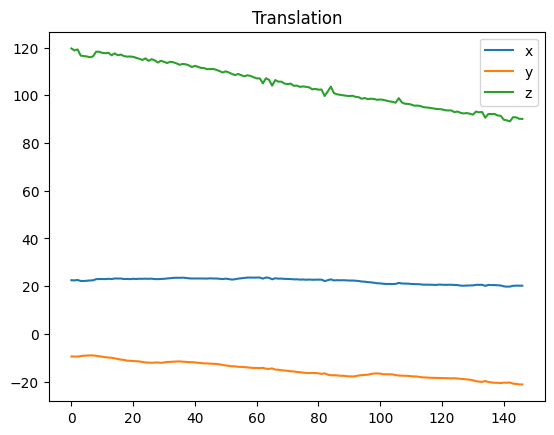

In [58]:
x_list=[]
y_list=[]
z_list=[]

for i in range(len(translation)):
    x = translation[i][0]
    x_list.append(x)
    y = translation[i][1]
    y_list.append(y)
    z = translation[i][2]
    z_list.append(z)
plt.title("Translation")
plt.plot(x_list,label='x')
plt.plot(y_list,label='y')
plt.plot(z_list,label='z')
plt.legend(["x","y","z"])


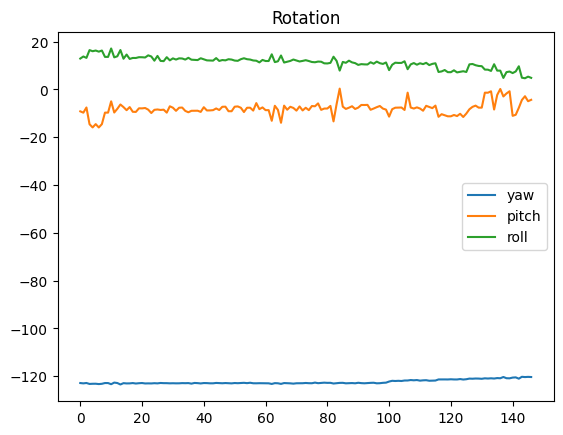

In [61]:
yaw=[]
pitch=[]
roll=[]
rotation = np.array(rotation)
for i in rotation:
    yaw.append(np.degrees(np.arctan2(i[1][0],i[0][0])))
    pitch.append(np.degrees(np.arctan2(-i[2][0],np.sqrt(np.square(i[2][1])+np.square(i[1][1])))))
    roll.append(np.degrees(np.arctan2(i[2][1],i[2][2])))
plt.title("Rotation")
plt.plot(yaw)
plt.plot(pitch)
plt.plot(roll)
plt.legend(['yaw','pitch','roll'])

### Hough Transformation